In [197]:
import warnings

warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 0

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Peaks data
from scipy.io import mmread

%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 120

sc.set_figure_params(figsize=(4,4),dpi=120)

<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
/tmp/ipykernel_27064/2971556966.py:3: DeprecationWarning: invalid escape sequence \.
  warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [198]:
import os
os.chdir('/lustre/scratch/kiviaho/spatac/')

## ATAC Preprocessing from ArchR output

In [199]:
# ATAC PREPROCESSING ACCORDING TO:
# https://github.com/dpeerlab/SEACells/blob/main/notebooks/ArchR/ArchR-preprocessing.ipynb
data_dir = '/lustre/scratch/kiviaho/spatac/data/tonsilatlas/multiome/ArchR/tonsil_mutiome/export/'

In [201]:
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [204]:
# Downloatac cell and peak information 
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:804692-805192,chr1,804692,805192,501,*,8.98391,0.415,0.186,2,C6._.Rep1,FAM87B,12429,Distal,9,uc057aum.1,0.4012,1,0
chr1:812845-813345,chr1,812845,813345,501,*,15.21570,0.675,0.310,2,C2._.Rep1,FAM87B,4276,Distal,4275,uc057aum.1,0.4331,2,0
chr1:827299-827799,chr1,827299,827799,501,*,21.15940,0.982,0.964,2,C1._.Rep2,LINC01128,2411,Promoter,26,uc057auo.1,0.6886,3,0
chr1:865569-866069,chr1,865569,866069,501,*,96.41840,0.846,0.589,2,C7._.Rep1,FAM41C,2252,Distal,4381,uc057aux.1,0.4451,4,0
chr1:869627-870127,chr1,869627,870127,501,*,22.65550,0.960,0.902,2,C11._.Rep2,FAM41C,1806,Intronic,323,uc057aux.1,0.7126,5,0


In [205]:
# Create anndata object and atacd annotations
atac = sc.AnnData(counts.T)
atac.obs_names = cells
atac.var_names = peaks.index
for col in peaks.columns:
    atac.var[col] = peaks[col]

atac.X = atac.X.tocsr()
atac.raw = atac.copy()

atac.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[atac.obs_names, : ].values

cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[atac.obs_names, : ]
for col in cell_meta.columns:
    atac.obs[col] = cell_meta[col].values

# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

atac.obsm['GeneScores'] = gene_scores.loc[atac.obs_names, :].values
atac.uns['GeneScoresColums'] = gene_scores.columns.values

atac.obs_names = [bc.split('#')[1] for bc in atac.obs_names] # remove archr project identifier
atac

/tmp/ipykernel_27064/661737169.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atac = sc.AnnData(counts.T)


AnnData object with n_obs × n_vars = 5442 × 146117
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'GeneScores'

### Preprocess RNA from 10x output

In [206]:
rna = sc.read_10x_mtx('./data/tonsilatlas/multiome/BCLLATLAS_42_43/ulx1v6sz_8a2nvf1c/filtered_feature_bc_matrix/')

In [207]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_rna = sc.AnnData(rna.X)
raw_rna.obs_names, raw_rna.var_names = rna.obs_names, rna.var_names
rna.raw = raw_rna
rna

AnnData object with n_obs × n_vars = 7181 × 36601
    var: 'gene_ids', 'feature_types'

### Intersect ATAC & RNA cells, integrate ready-made annotations

In [208]:
# Download annotations
rna_annot = pd.read_csv('./data/tonsilatlas/tonsilatlas_cell_annotations_20220619.csv')

broad_celltypes = ["NBC-MBC","GCBC","PC","CD4-T","Th","CD8-T","ILC-NK",
"myeloid","FDC","epithelial","PDC","preB","preT"]

# Filter all but one experiment
exp_id = 'ulx1v6sz_8a2nvf1c' # add '|2nd exp|3rd exp|etc.' 
rna_annot = rna_annot[rna_annot['Barcode'].str.contains(exp_id)] # only keep the one experiment
rna_annot['Barcode'] = rna_annot['Barcode'].str.replace(exp_id+'_','') # strip experiment id
rna_annot = rna_annot.set_index('Barcode')

In [209]:
# Filter out cells without an annotation in both modalities
shared_cells = np.intersect1d(np.intersect1d(rna.obs.index,atac.obs.index),rna_annot.index)

atac = atac[atac.obs.index.isin(shared_cells)]
rna = rna[rna.obs.index.isin(shared_cells)]
rna_annot = rna_annot[rna_annot.index.isin(shared_cells)]

# Sort to the same order
atac = atac[atac.obs.sort_index().index]
rna = rna[rna.obs.sort_index().index]
rna_annot = rna_annot.sort_index()

# Check that the dataframes are in the same order & copy annotation
if all(atac.obs.index == rna.obs.index) & all(rna_annot.index == rna.obs.index):
    print('Success')
    atac.obs['celltype'] = rna_annot['celltype']
    rna.obs['celltype'] = rna_annot['celltype']

Success


/tmp/ipykernel_27064/2671918563.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  atac.obs['celltype'] = rna_annot['celltype']
/tmp/ipykernel_27064/2671918563.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna.obs['celltype'] = rna_annot['celltype']


### Plot ATAC & RNA in UMAP spaces

In [230]:
# Leiden and UMAP for ATAC data
warnings.filterwarnings('ignore')
sc.pp.neighbors(atac, use_rep='X_svd')
sc.tl.umap(atac)
sc.tl.leiden(atac)
warnings.filterwarnings('default')

In [231]:
# Leiden and UMAP for RNA data s
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, n_top_genes=1500)
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(rna, n_comps=50, use_highly_variable=True)
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=40)
sc.tl.umap(rna)
sc.tl.leiden(rna)

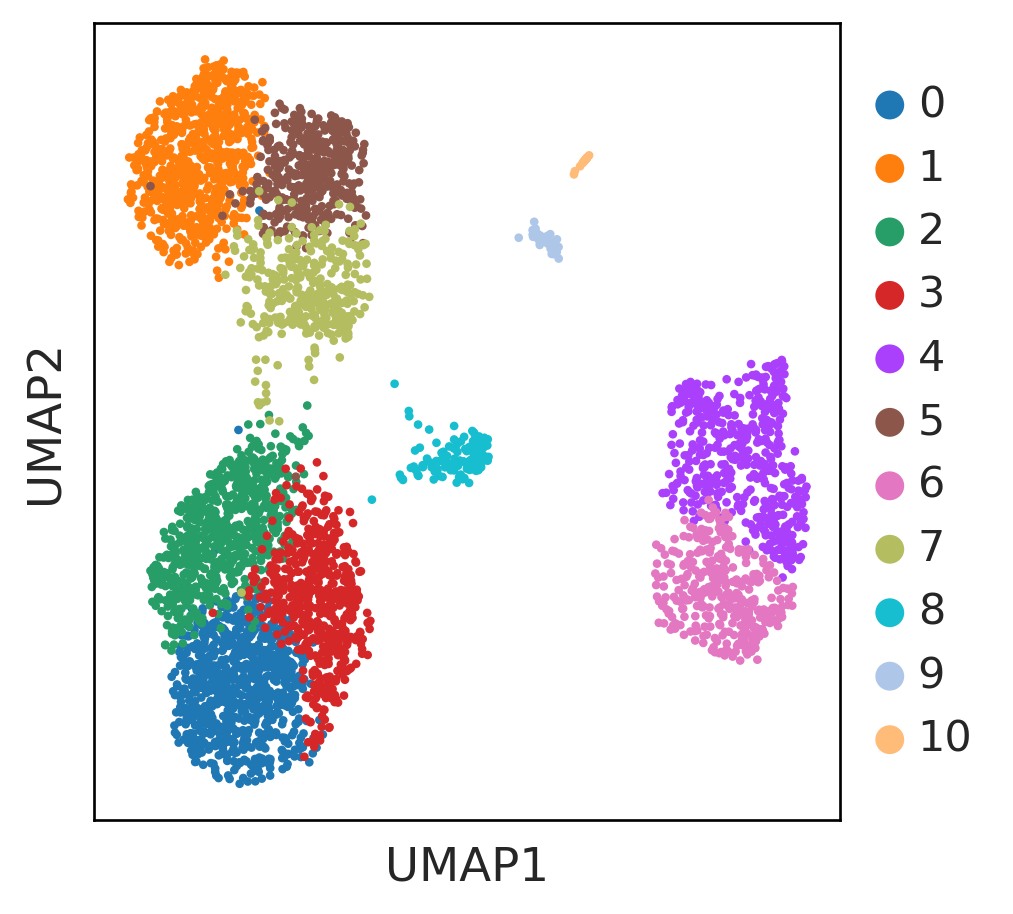

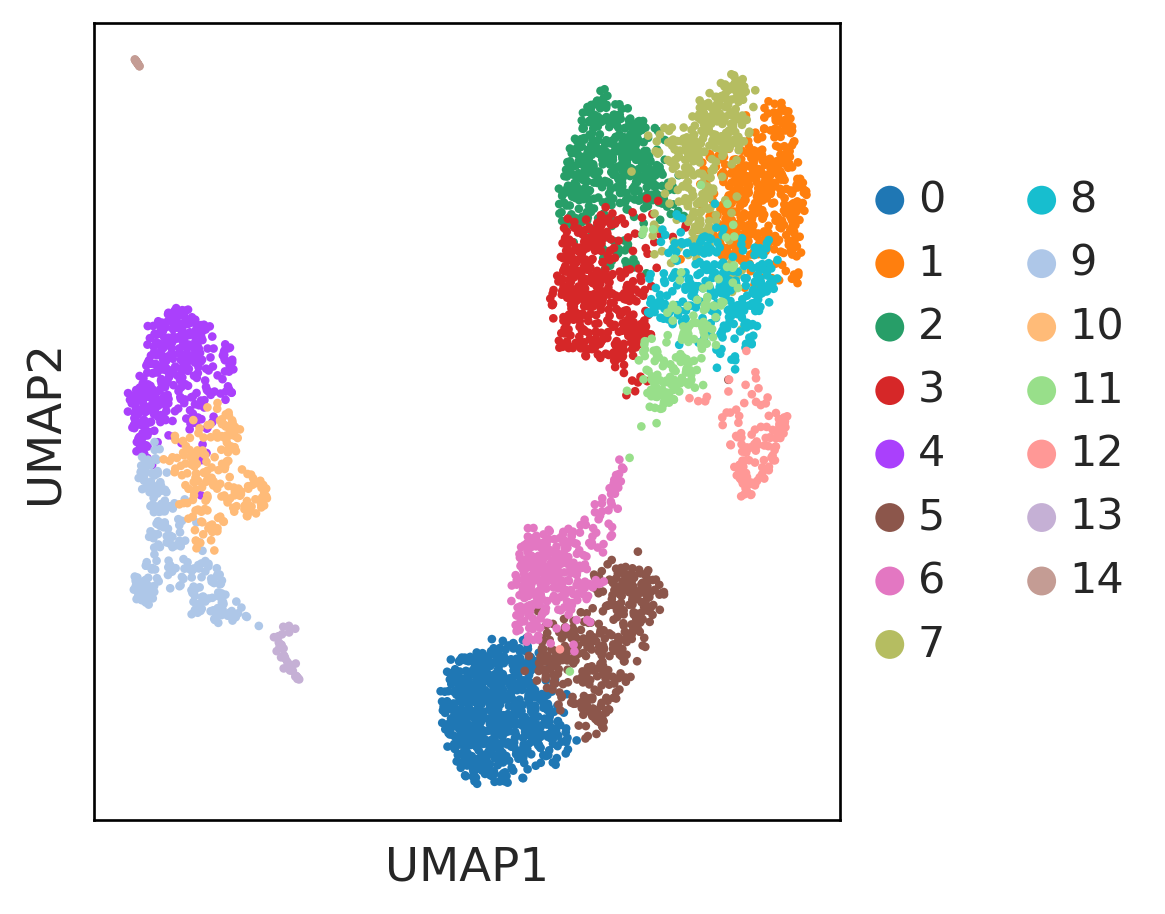

In [232]:
# plot with own leiden clusters
sc.pl.scatter(atac,basis='umap',color='leiden',title='')
sc.pl.scatter(rna,basis='umap',color='leiden',title='')

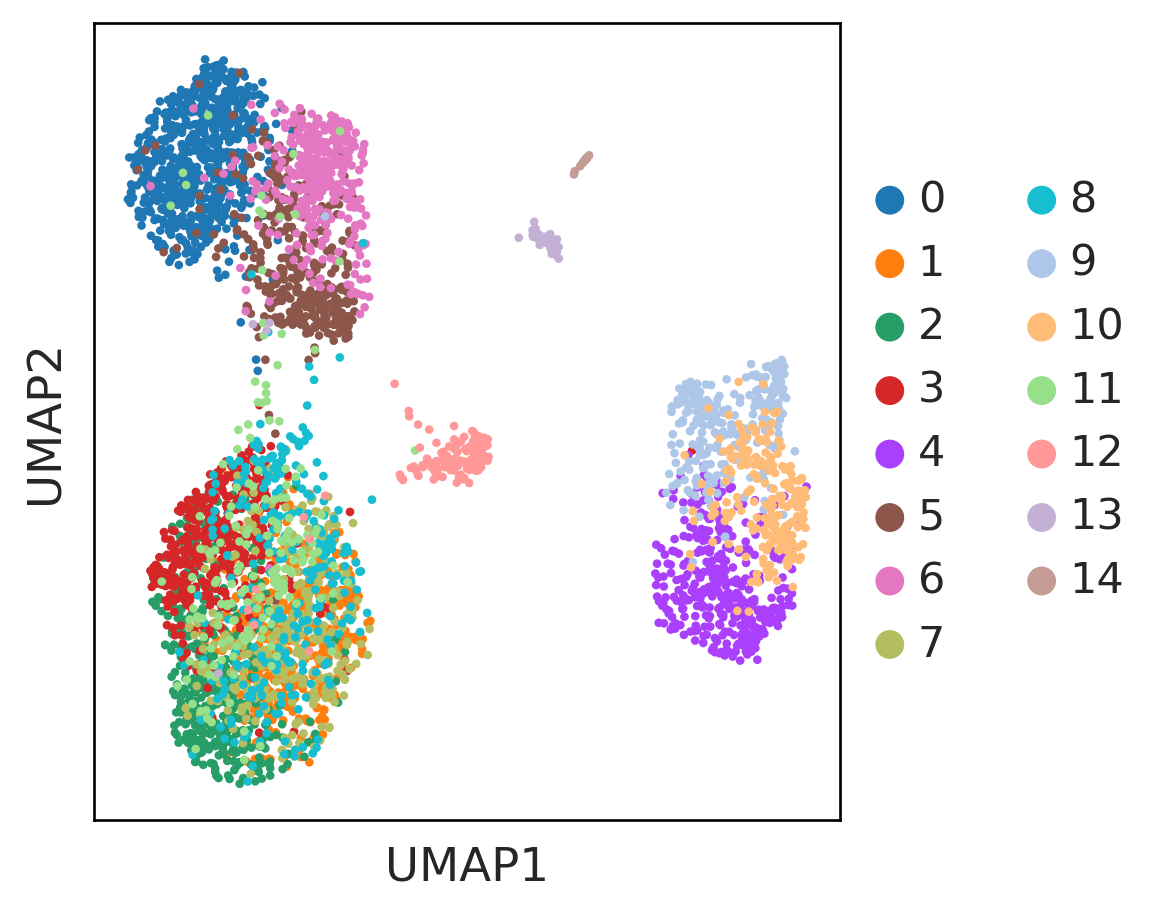

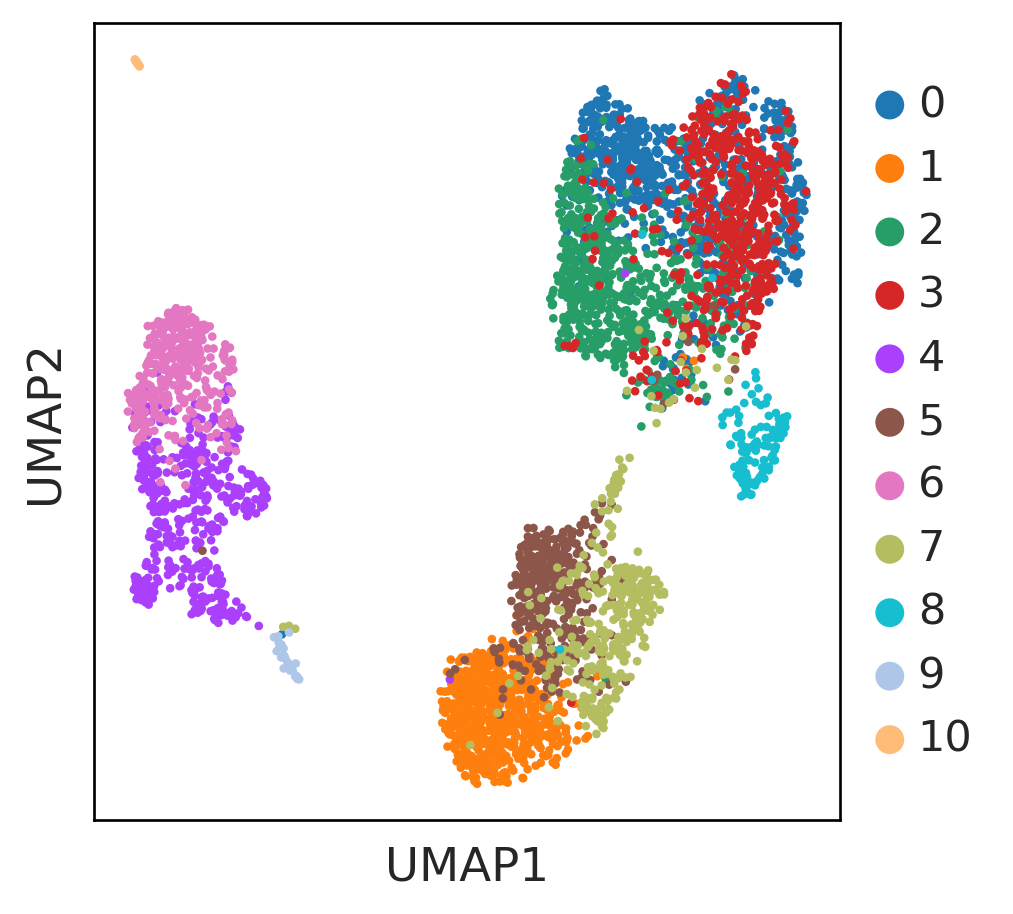

In [233]:
# plot with each others leiden clusters
atac.obs['rna_leiden'] = rna.obs.leiden
rna.obs['atac_leiden'] = atac.obs.leiden
sc.pl.scatter(atac,basis='umap',color='rna_leiden',title='')
sc.pl.scatter(rna,basis='umap',color='atac_leiden',title='')

In [248]:
# Check the cell type annotations of cluster
#broad_celltypes = ["NBC-MBC","GCBC","PC","CD4-T","Th","CD8-T","ILC-NK",
#"myeloid","FDC","epithelial","PDC","preB","preT"]

leiden_id = ['1'] # Change this number to view the most prolific cell types present in a leiden cluster
rna[rna.obs.leiden.isin(leiden_id)].obs['celltype'].value_counts() 

DZ late Sphase                    140
DZ late G2Mphase                  124
DZ early G2Mphase                 115
DZ early Sphase                    36
LZ_DZ transition                   13
LZ proliferative                   10
DZ cell cycle exit                  3
PC committed Light Zone GCBC        1
Reactivated proliferative MBCs      1
Name: celltype, dtype: int64

In [258]:
# create broader annotations with respect to clusters
rna.obs['broad_celltype'] = rna.obs['leiden'].map(
    {'0': 'NBC-MBC',
 '1':'GCBC',
 '2':'GCBC',
 '3':'GCBC',
 '4':'Th',
 '5':'NBC-MBC',
 '6':'NBC-MBC',
 '7':'GCBC',
 '8':'GCBC',
 '9':'CD8-T',
 '10':'Th',
 '11':'preB',
 '12':'PC',
 '13':'myeloid',
 '14':'PDC',
 })
if all(atac.obs_names == rna.obs_names):
    atac.obs['broad_celltype'] = rna.obs['broad_celltype']

In [269]:
# Plot UMAPs for saving
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
sc.pl.scatter(rna,basis='umap',color='leiden',title='',ax=ax1,legend_loc='none',frameon=False,show=False)
plt.savefig('./plots/tonsil-rna-scatter-with-own-leiden.png',dpi=600)
plt.clf()

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
sc.pl.scatter(atac,basis='umap',color='leiden',title='',ax=ax1,legend_loc='none',frameon=False,show=False)
plt.savefig('./plots/tonsil-atac-scatter-with-own-leiden.png',dpi=600)
plt.clf()

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
sc.pl.scatter(rna,basis='umap',color='atac_leiden',title='',ax=ax1,legend_loc='none',frameon=False,show=False)
plt.savefig('./plots/tonsil-rna-scatter-with-atac-leiden.png',dpi=600)
plt.clf()

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
sc.pl.scatter(atac,basis='umap',color='rna_leiden',title='',ax=ax1,legend_loc='none',frameon=False,show=False)
plt.savefig('./plots/tonsil-atac-scatter-with-rna-leiden.png',dpi=600)
plt.clf()




<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

In [270]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(12,8)
sc.pl.scatter(atac,basis='umap',color='leiden',title='',ax=ax1,frameon=True,show=False,color_map='Set2')
fig.tight_layout()
plt.savefig('./plots/tonsil-scatter-atac-clusters.png',dpi=300)
plt.clf()

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(12,8)
sc.pl.scatter(rna,basis='umap',color='leiden',title='',ax=ax1,frameon=True,show=False,color_map='Set2')
fig.tight_layout()
plt.savefig('./plots/tonsil-scatter-rna-clusters.png',dpi=300)
plt.clf()

<Figure size 1440x960 with 0 Axes>

<Figure size 1440x960 with 0 Axes>

## Integrate broader labels and save both data

In [268]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
sc.pl.scatter(rna,basis='umap',color='broad_celltype',title='',ax=ax1,legend_loc='none',frameon=False,show=False,color_map='Set2')
plt.savefig('./plots/tonsil-rna-scatter-with-broad-celltype.png',dpi=600)
plt.clf()

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
sc.pl.scatter(atac,basis='umap',color='broad_celltype',title='',ax=ax1,legend_loc='none',frameon=False,show=False,color_map='Set2')
plt.savefig('./plots/tonsil-atac-scatter-with-broad-celltype.png',dpi=600)
plt.clf()

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(12,8)
sc.pl.scatter(atac,basis='umap',color='broad_celltype',title='',ax=ax1,frameon=True,show=False,color_map='Set2')
fig.tight_layout()
plt.savefig('./plots/tonsil-scatter-broad-celltype.png',dpi=300)
plt.clf()

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 1440x960 with 0 Axes>

In [274]:
atac.write('./data/atac_tonsil_multiome.h5ad')
rna.write('./data/rna_tonsil_multiome.h5ad')
